# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [1]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re

In [2]:
df = pd.read_csv('results/all_results_average.csv')


df = df.rename(columns={'lag_time': 't', 'n_components': 'm', 'n_clusters': 'n', 'test_score': 'y'}).\
loc[:, ['basis', 'method', 'y', 't', 'm', 'n']]

to_scale = ['m', 'n', 't']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_s' for x in to_scale])
df = df.join(vars_scaled)

In [3]:
idx = (df['basis'] == 'ppo_tor') & (df['method'] == 'random') 
X = df.loc[idx, :].filter(regex='_s$')
y = df.loc[idx, 'y']

In [4]:
X_c = pt.dmatrix('t_s + C(m_s) + n_s', data=X, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))
X_c = X_c.rename(columns=lambda x: x[:10])
X_c = X_c.iloc[:, 1:X_c.shape[1]] # Remove intercept

## Priors

In [5]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


In [6]:
l_priors = [(1, 0.01), (1, 0.05), (1, 0.1)]
e_priors = [3, 2, 1]
s_priors = [3, 2, 1]

### Gamma - length scales

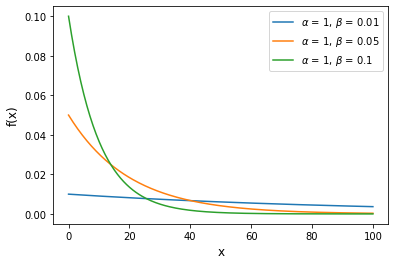

In [7]:
import scipy.stats as st
x = np.linspace(0, 100, 200)
# alphas = [1., 2., 3., 7.5]
# betas = [.5, .5, 1., 1.]
for a, b in l_priors:
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

### Half-Cauchy - Variance parameters

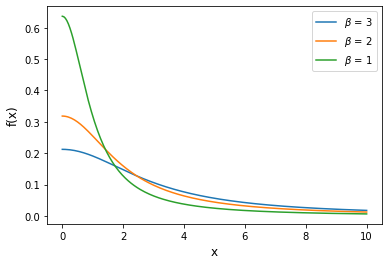

In [8]:
x = np.linspace(0, 10, 200)
for b in e_priors:
    hc = pm.HalfCauchy.dist(beta=b)
    pdf = np.exp(hc.logp(value=x).eval())
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)

In [9]:
prior_idx = 1

##  Model 1 - full Bayes

All variables treated as continuous. RBF kernel on all of them. 

In [10]:
# def fit_model(y, X, prop_Xu, l_prior, eta_prior, sigma_prior, n=500, n_chains=2):
#     """
#     function to return a pymc3 model
#     y : dependent variable
#     X : independent variables
#     prop_Xu : number of inducing varibles to use
#     l/eta/sigma_prior : the prior for the various hyperparameters
    
#     X, y are dataframes. We'll use the column names. 
#     """
    
#     with pm.Model() as model:
        
#         # labels
#         X_labs = ['l_'+ x[:5] for x in X.columns]
#         y_lab = y.name
        
#         # Covert arrays
#         X = X.values
#         y = y.values
        
#         # Length priors
#         length_priors = []
#         for i in range(len(X_labs)):
#             length_priors.append(l_prior(X_labs[i]))

#         # covariance prior
#         eta = eta_prior('eta')
        
#         # Covariance function
#         cov = eta**2
#         for i in range(len(X_labs)):
#             cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i])

#         # Sparse Model
#         # Shift the mean function up to mean of response values. 
#         # This is to increase speed of convergence. Could equally 
#         # have shifted response to zero. 
#         gp = pm.gp.MarginalSparse(pm.gp.mean.Constant(c=2), cov_func=cov, approx="FITC")
        
#         # Noise model
#         sigma_n = sigma_prior('sigma_n')
        
#         # Inducing variables
#         num_Xu = int(X.shape[0]*prop_Xu)
#         Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
#         # Marginal likelihood
#         y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
#         # Sample
#         trace = pm.sample(draws=n, chains=n_chains, cores=1)
        
#     return model, trace, gp

    

In [11]:
# model, trace, gp = fit_model(y=y, X=X, prop_Xu = 0.1, 
#                          l_prior=gamma(*l_priors[prior_idx]), 
#                          sigma_prior=hcauchy(s_priors[prior_idx]), 
#                          eta_prior=hcauchy(s_priors[prior_idx]), n=500, n_chains=2)

In [12]:
# def plot_model_predictions(model, trace, X_old):
#     # create a variable to call the prediction
#     r = re.compile('f_pred([0-9]+)')
#     var_names = [x.name for x in model.cont_vars] 

#     max_num = [int(r.search(x).group(1)) for x in var_names if r.search(x) is not None]
#     if len(max_num): 
#         max_num = np.max(max_num)
#     else:
#         max_num = 0
#     var_pred = 'f_pred{}'.format(max_num + 1)
    
#     with model:
#         n = 250
#         f_pred = gp.conditional(var_pred, X_old.values)
#         pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=n)
    
#     plt.scatter(np.tile(y.values, n), pred_samples[var_pred].flatten(), alpha=0.1)
#     plt.xlim(1.1, 2.3)
#     plt.ylim(1.1, 2.3)
#     plt.plot(np.array([1.1, 2.3]),np.array([1.1, 2.3]))
#     plt.xlabel('y_true')
#     plt.ylabel('y_pred')
#     return plt.gca(), pred_samples[var_pred]
    
    


In [13]:
# ax, pred_samples = plot_model_predictions(model, trace, X)

## Models list

Using `fit_model_1`:

    1. RBF with `m` continuous
    2. RBF with `m` categorical - use code for model `1`
    3. Exponential with `m` categorical. 


In [23]:
def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

In [42]:
# Inputs
exp_labs = ['Continuous', 'Continuous', 'Categorical', 'Categorical']
predictors = [X, X, X_c, X_c]
targets = [y, y, y, y]
kernels = ['RBF', 'Exponential', 'RBF','Exponential']

# Outputs
pred_dfs = []


for i in range(len(exp_labs)):
    
    gp, mp, model = fit_model_1(y=targets[i], X = predictors[i], kernel_type=kernels[i])
    
    with model:
        # predict latent
        mu, var = gp.predict(predictors[i].values, point=mp, diag=True,pred_noise=False)
        sd_f = np.sqrt(var)
        # predict target
        _, var = gp.predict(predictors[i].values, point=mp, diag=True,pred_noise=True)
        sd_y = np.sqrt(var)
    res = pd.DataFrame({'f_pred': mu, 'sd_f': sd_f, 'sd_y': sd_y, 'y': targets[i]})
    res.loc[:, 'kernel'] = kernels[i]
    res.loc[:, 'm_type'] = exp_labs[i]
    res.loc[:, 'experiment'] = kernels[i]+'-'+exp_labs[i]
    
    pred_dfs.append(pd.concat([X, res], axis=1))

pred_dfs = pd.concat(pred_dfs)
    
        
    

logp = 30.692, ||grad|| = 0.73809: 100%|██████████| 31/31 [00:00<00:00, 206.52it/s]  
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 28.4, ||grad|| = 0.088642

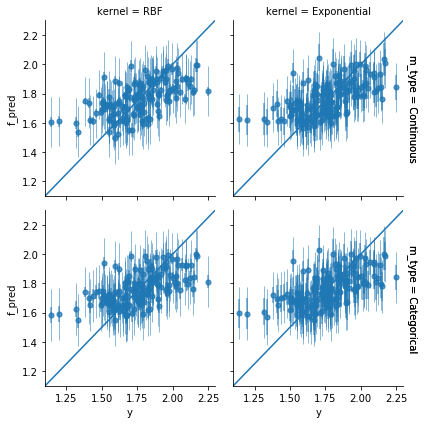

In [43]:
lims = (1.1, 2.3)
g = sns.FacetGrid(data=pred_dfs, col='kernel', row='m_type', margin_titles=True)
g.map(plt.errorbar, 'y', 'f_pred', 'sd_f', lw=0, elinewidth=2, alpha=0.5, marker='o', ms=5)
g.map(plt.errorbar, 'y', 'f_pred', 'sd_y', lw=0, elinewidth=1, alpha=0.5, marker='o', ms=5)
for ax in g.axes.flatten():
    ax.plot(lims, lims)
g.set(xlim=lims, ylim=lims)

In [44]:
pred_dfs['sll'] = 0.5*np.log(2*np.pi*pred_dfs['sd_y']**2) + (pred_dfs['f_pred']-pred_dfs['y'])**2/(2*pred_dfs['sd_y']**2)

pred_dfs.groupby('experiment')['sll'].mean()

experiment
Exponential-Categorical   -0.392698
Exponential-Continuous    -0.406376
RBF-Categorical           -0.385449
RBF-Continuous            -0.387820
Name: sll, dtype: float64

In [45]:
pred_dfs['smse'] = (pred_dfs['f_pred']-pred_dfs['y'])**2/(pred_dfs['sd_y']**2)
pred_dfs.groupby('experiment')['smse'].mean()

experiment
Exponential-Categorical    0.828909
Exponential-Continuous     0.871543
RBF-Categorical            0.867291
RBF-Continuous             0.931483
Name: smse, dtype: float64

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an er

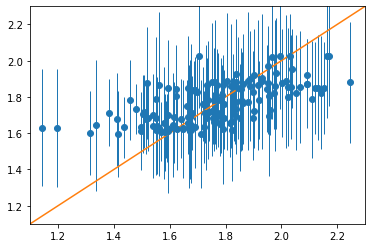

In [109]:
with pm.Model() as model:
    # Names
    y_lab = y.name

    # Covert arrays
    X_a = dd.values
    y_a = y.values
    X_cols = list(dd.columns)
    
    # params
    prop_Xu = 0.1
    l_prior = gamma(1, 0.05)
    eta_prior = hcauchy(2)
        
    # 3 way interaction
    eta = eta_prior('eta')
    cov = eta**2
    for i in range(X_a.shape[1]):
        var_lab = 'l_'+X_cols[i]
        cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

#     # 2 way n x m i.e. excluding t
#     eta2 = eta_prior('eta_2')
#     cov2 = eta2**2
#     for i in range(X_a.shape[1]):
#         if X_cols[i][0] != 't':
#             var_lab = 'l_'+X_cols[i][:8]+'_2'
#             cov2 = cov2*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])


    cov_tot = cov
    
    # Sparse Model
    # Shift the mean function up to mean of response values. 
    # This is to increase speed of convergence. Could equally 
    # have shifted response to zero. 
    # pm.gp.mean.Constant(c=3),
    gp = pm.gp.MarginalSparse(pm.gp.mean.Constant(c=2), cov_func=cov_tot, approx="FITC")

    # Noise model
    sigma_n = pm.HalfCauchy('sigma', beta=2)

    # Inducing variables
    num_Xu = int(X_a.shape[0]*prop_Xu)
    Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

    # Marginal likelihood
    y_ = gp.marginal_likelihood(y_lab, X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
    mp = pm.find_MAP()
    
    mu, var = gp.predict(X_a, point=mp, diag=True,pred_noise=False)
    sd = np.sqrt(var)
    
    plt.errorbar(y_a, mu, yerr=2*sd, marker='o', elinewidth=1, lw=0)
    lims = (1.1, 2.3)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)

    

INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
INFO (theano.gof.compilelock): Refreshing lock /Users/robertarbon/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir/lock
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

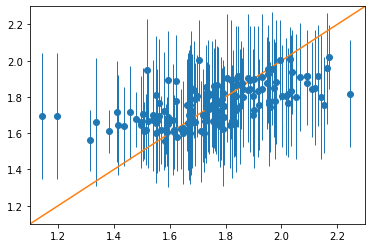

In [110]:
with pm.Model() as model:
    # Names
    y_lab = y.name

    # Covert arrays
    X_a = dd.values
    y_a = y.values
    X_cols = list(dd.columns)
    
    # params
    prop_Xu = 0.1
    l_prior = gamma(1, 0.05)
    eta_prior = hcauchy(2)
        
    
    # 3 way interaction
    eta = eta_prior('eta')
    cov = eta**2
    for i in range(X_a.shape[1]):
        var_lab = 'l_'+X_cols[i]
        cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

            
#     # 2 way n x m i.e. excluding t
#     eta2 = eta_prior('eta_2')
#     cov2 = eta2**2
#     for i in range(X_a.shape[1]):
#         if X_cols[i][0] != 't':
#             var_lab = 'l_'+X_cols[i][:8]+'_2'
#             cov2 = cov2*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

    # m_components only
    eta3 = eta_prior('eta_3')
    cov3 = eta3**2
    for i in range(X_a.shape[1]):
        if X_cols[i][0] == 'm':
            var_lab = 'l_'+X_cols[i][:8]+'_3'
            cov3 = cov3*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
    
    # n_components only
    eta4 = eta_prior('eta_4')
    cov4 = eta4**2
    for i in range(X_a.shape[1]):
        if X_cols[i][0] == 'n':
            var_lab = 'l_'+X_cols[i][:8]+'_4'
            cov4 = cov4*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

    cov_tot = cov + cov3 + cov4
    
    # Sparse Model
    # Shift the mean function up to mean of response values. 
    # This is to increase speed of convergence. Could equally 
    # have shifted response to zero. 
    # pm.gp.mean.Constant(c=3),
    gp = pm.gp.MarginalSparse(pm.gp.mean.Constant(c=2), cov_func=cov_tot, approx="FITC")

    # Noise model
    sigma_n = pm.HalfCauchy('sigma', beta=2)

    # Inducing variables
    num_Xu = int(X_a.shape[0]*prop_Xu)
    Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

    # Marginal likelihood
    y_ = gp.marginal_likelihood(y_lab, X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
    mp = pm.find_MAP()
    
    mu, var = gp.predict(X_a, point=mp, diag=True,pred_noise=False)
    sd = np.sqrt(var)
    
    plt.errorbar(y_a, mu, yerr=2*sd, marker='o', elinewidth=1, lw=0)
    lims = (1.1, 2.3)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)

    